In [43]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [44]:
#Open data file
hdulist = fits.open('/Users/jfarr/Projects/LyaCoLoRe/example_data/raw_colore/test_N1000.fits')

#Extract redshift from data file
z = hdulist[4].data['Z']
z = np.asarray(z)

#Extract the density skewers from data file
delta_skewers = hdulist[2].data
delta_squared_skewers = density_skewers**2

In [45]:
#Get number of quasars and cells, as well as a list of quasar redshifts
z_qso = hdulist[1].data['Z_COSMO']
N_qso = len(z_qso)
N_cells = delta_skewers.shape[1]
print('There are %d quasars in the sample.' % N_qso)
print('There are %d cells in each skewer.' % N_cells)

There are 1000 quasars in the sample.
There are 2048 cells in each skewer.


In [46]:
#Make a mask to remove irrelevant data when averaging (deltas for z>z_qso)
mask = np.ones(delta_skewers.shape)
max_pixel_qso = [0.]*N_qso
for j in range(N_qso):
    max_pixel_qso[j] = (np.argmax(z>z_qso[j]))%N_cells
    mask[j,max_pixel_qso[j]+1:]=np.zeros(1,(mask.shape[1]-max_pixel_qso[j]-1))

In [47]:
#Calculate the average delta over all skewers
mean_delta = np.zeros(N_cells)
for j in range(N_cells):
    if sum(mask[:,j])!=0:
        mean_delta[j] = np.average(delta_skewers[:,j],weights=mask[:,j])

#Calculate the average delta squared over all skewers
mean_delta_squared = np.zeros(N_cells)
for j in range(N_cells):
    if sum(mask[:,j])!=0:
        mean_delta_squared[j] = np.average(delta_squared_skewers[:,j],weights=mask[:,j])

#Show the mean delta over all z.
print('The mean delta over all z is %f.' % np.average(mean_delta))

The mean delta over all z is 0.208670.


In [48]:
#Set up the binned data structure
N_bins = 100
binned_z = np.zeros(N_bins)
binned_z_location = np.zeros(N_bins)
binned_mean_delta = np.zeros(N_bins)
binned_delta_var = np.zeros(N_bins)

In [49]:
#Construct the conversion matrix: an N_bins by N_cells matrix detailing the contribution of each cell to each bin
#conversion[i,j] denotes the contribution of the jth cell to the ith bin
conversion = np.zeros((N_bins,N_cells))
ratio = N_cells/N_bins
for i in range(N_bins):
    unassigned_row_contribution=ratio
    for j in range(N_cells):
        unassigned_col_contribution=1-sum(conversion[:,j])
        if unassigned_row_contribution>0:
            conversion[i,j] = min(unassigned_row_contribution,unassigned_col_contribution,1)
            unassigned_row_contribution -= conversion[i,j]
            unassigned_col_contribution -= conversion[i,j]
        else:
            break
    #Construct output vectors
    binned_z_location[i] = (i+0.5)*ratio + 0.5
    binned_mean_delta[i] = sum(conversion[i,:]*mean_delta)/ratio
    binned_delta_var[i] = sum(conversion[i,:]*mean_delta_squared)/ratio - (binned_mean_delta[i])**2

In [50]:
#Calculate the binned z values by linear interpolation
binned_z = np.interp(binned_z_location,list(range(N_cells)),z)

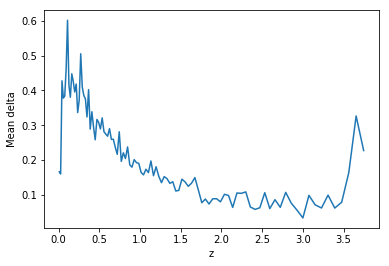

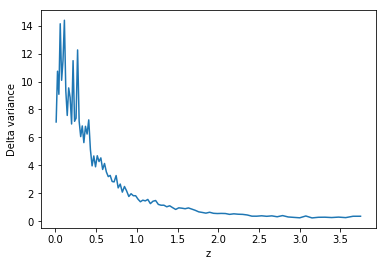

In [51]:
#Show the calculated statistics against z
plt.figure()
plot_binned_mean_delta = plt.plot(binned_z, binned_mean_delta)
plt.xlabel('z')
plt.ylabel('Mean delta')
plt.figure()
plot_binned_delta_var = plt.plot(binned_z, binned_delta_var)
plt.xlabel('z')
plt.ylabel('Delta variance')
plt.show()